In [1]:
import pandas as pd
import numpy as np
import pygmt

In [2]:

class Cpt:
    def __init__(self, cpt):
        cpt = pd.read_csv(cpt, sep='\t', header=None)
        self.cpt_o = cpt.iloc[-3:]
        cpt = cpt[:-3]
        cpt[0] = np.array(cpt[0]).astype(float)
        self.cpt = cpt
    def __call__(self, value):
        if value is None:
            return self.cpt_o.iloc[2, 1]
        idx = np.sum(self.cpt[0] < value) - 1
        if idx < 0:
            return self.cpt_o.iloc[0, 1]
        elif idx + 2 > self.cpt.shape[0]:
            return self.cpt_o.iloc[1, 1]
        else:
            return self.cpt.iloc[idx, 1]

cat = pd.read_csv('./aftershocks.csv')
cat['time'] = pd.to_datetime(cat['time'])
cat = cat[cat.time > pd.to_datetime('2024-12-05T18:44:21')]

       
cat_on_fault = pd.read_csv('./aftershocks_on_fault.csv')
cat_on_fault['time'] = pd.to_datetime(cat_on_fault['time'])
cat_on_fault = cat_on_fault[cat_on_fault.time > pd.to_datetime('2024-12-05T18:44:21')]


repeating_cat = pd.read_csv('./repeating_earthquakes.csv')
background = pd.read_csv('./background_seismicity.csv')
mainshock = pd.read_csv('./mainshock.csv')

static_inv = pd.read_csv('./static_inv.csv')
gnss = pd.read_csv('./gnss_data.csv')
static_inv_gnss_syn = pd.read_csv('./static_inv_gnss_syn.csv')
fault_cords = pd.read_csv('./fault_cords.csv')

kinematic_inv = pd.read_csv('./kinematic_inv.csv')
kinematic_inv_gnss_syn = pd.read_csv('./kinematic_inv_gnss_syn.csv')


cpt = Cpt('./slip.cpt')

stf = pd.read_csv('./stf.csv')
stf = stf[stf.time <= 21]
stf = pd.concat([stf, pd.DataFrame([[21, 0]], columns=['time', 'Moment_Rate'])])

back_projection = pd.read_csv('../figure1/back_projection.csv')

plot [WARNING]: Length <unit> d not supported - revert to default unit [cm]
plot [WARNING]:  not a valid number and may not be decoded properly.


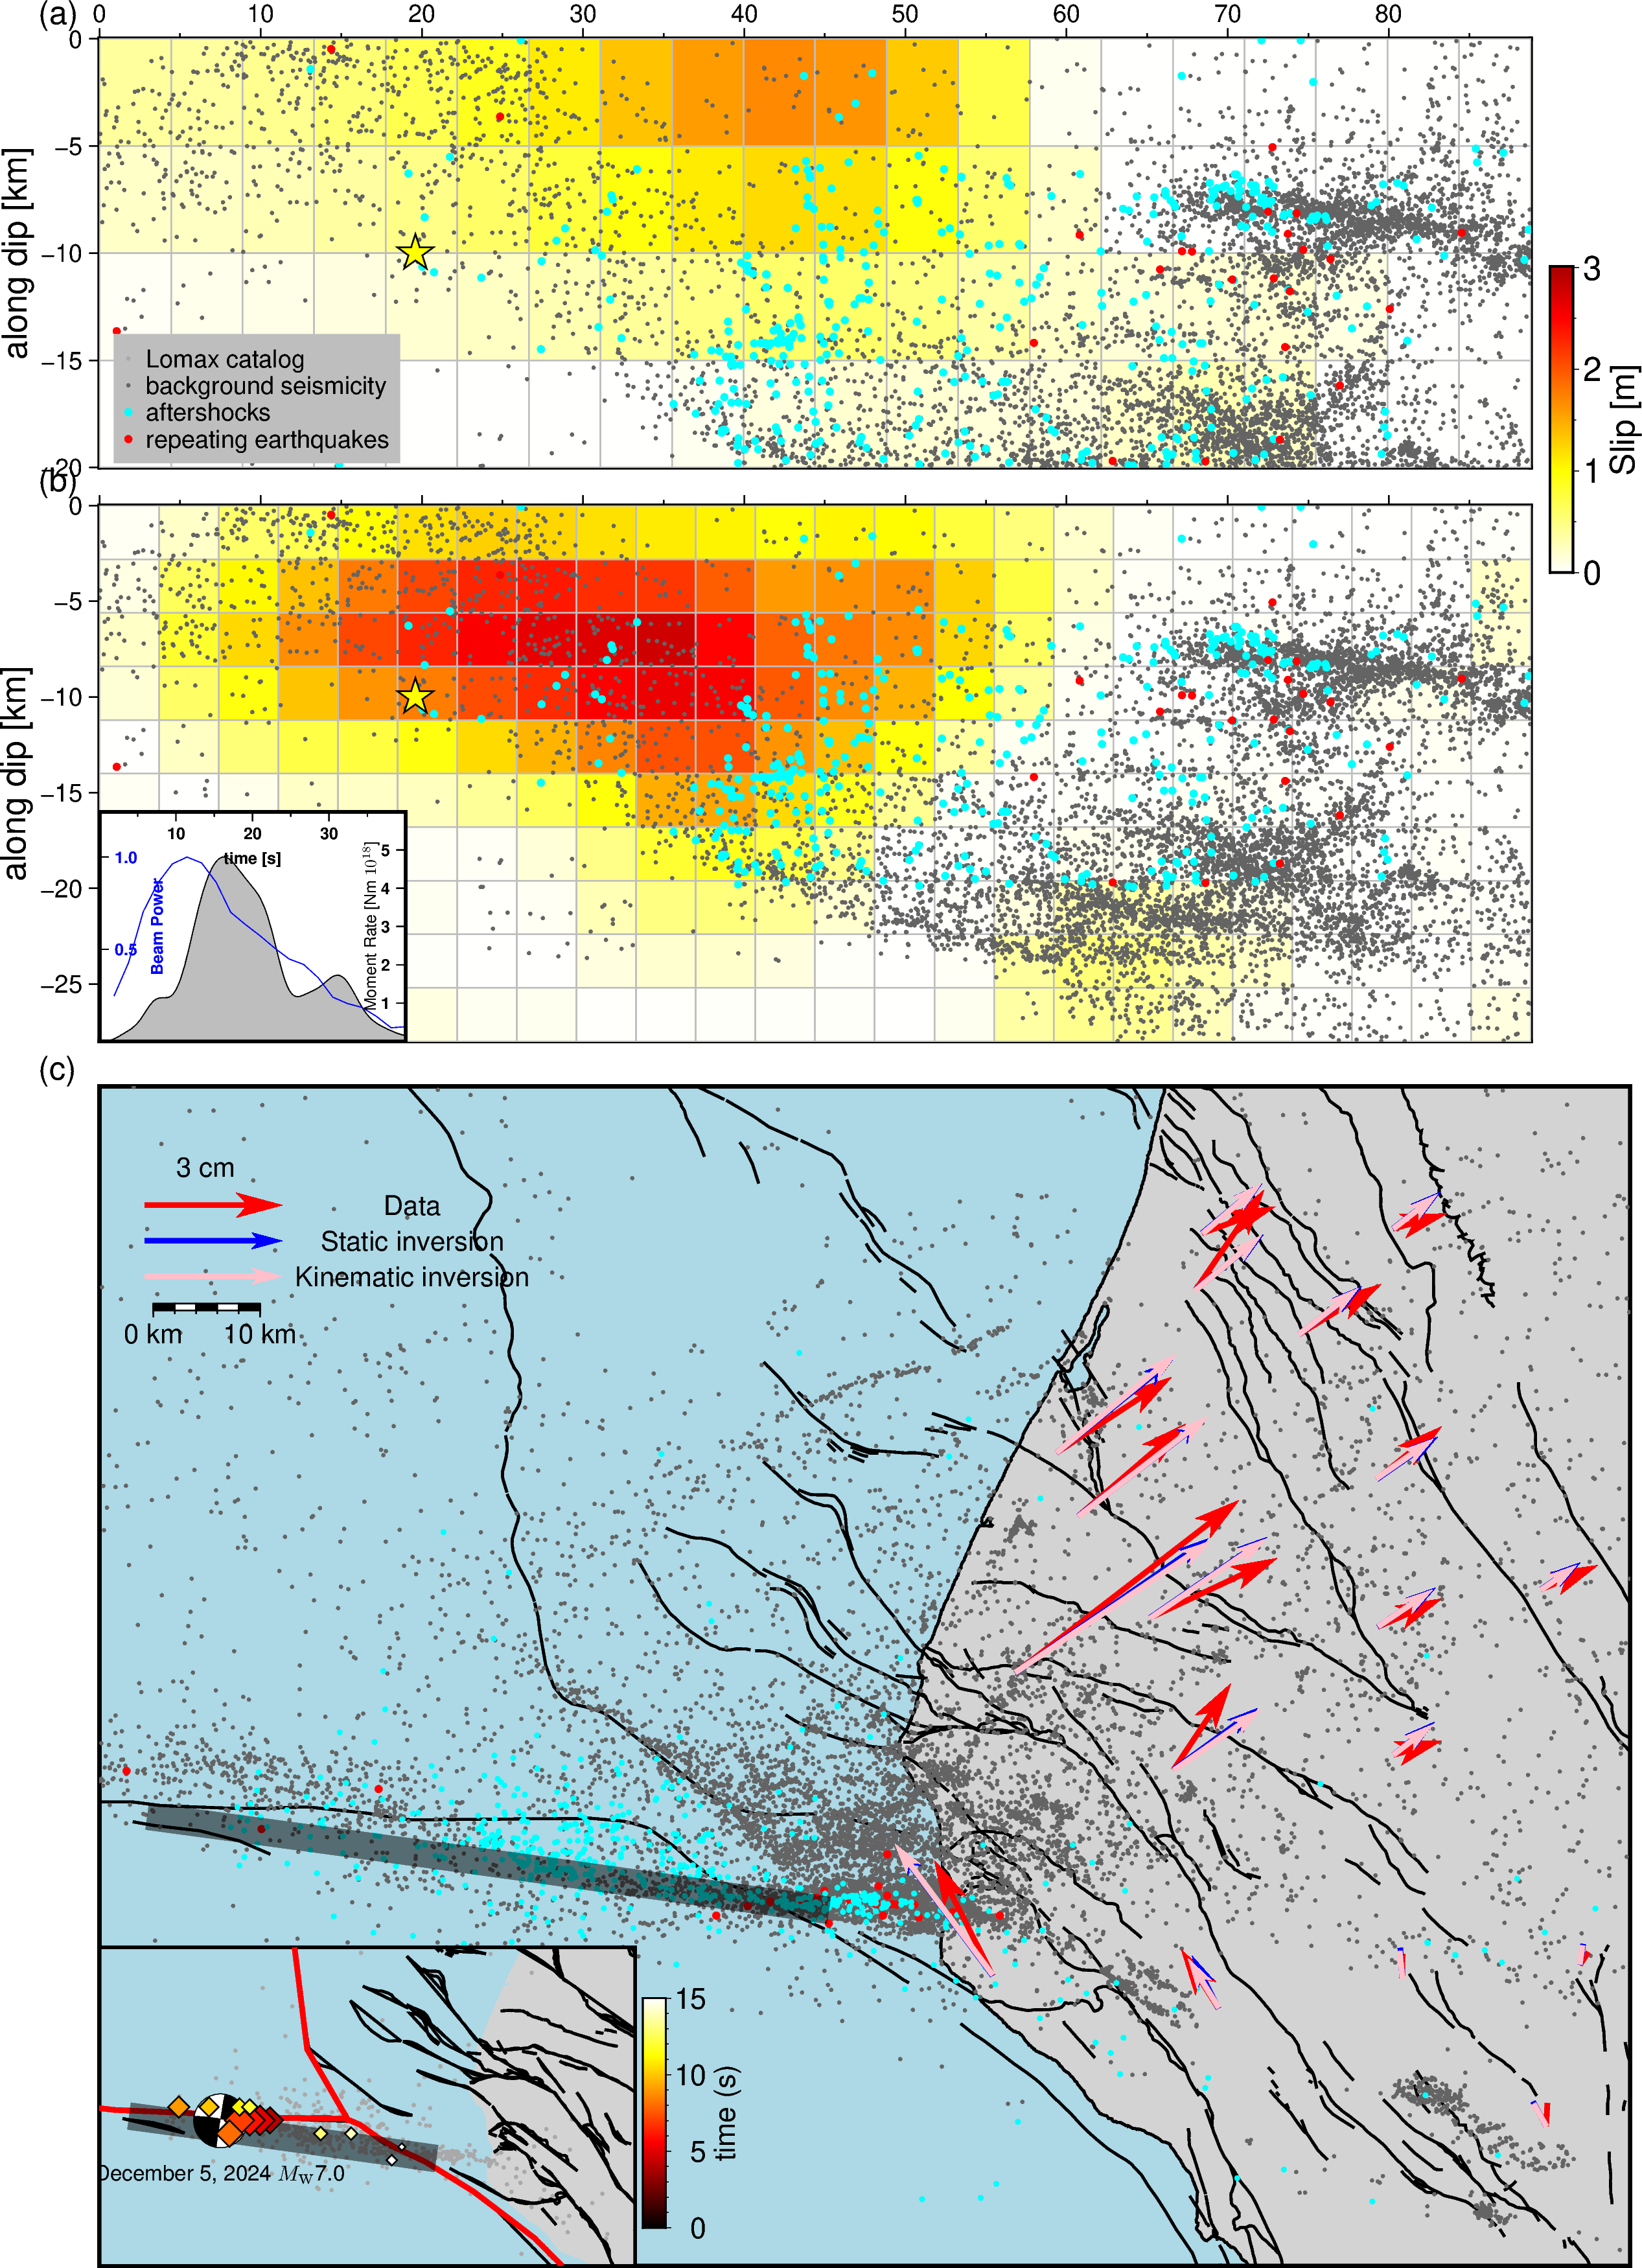

In [37]:
plot_kinematic = True
plot_seismicity  = True


region=[-125.3, -123.6, 40, 41]
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

#### panel c #####

fig.coast(
    frame=['lrtb'],
    projection=f"M20",
    region=region,
    shorelines='1p,black',
    land = 'lightgray',
    water='lightblue'
    
)
fig.plot(
    data='./faults.gmt',
    pen="1p,black",
)

if plot_seismicity:
    cc = 100
    fig.plot(
        x=background.lon,
        y=background.lat,
        style="c0.05c",
        fill=f'{cc}/{cc}/{cc}',
    )
    fig.plot(
        x=repeating_cat.lon,
        y=repeating_cat.lat,
        style="c0.1c",
        fill='red',
    )
    fig.plot(
        x=cat.lon,
        y=cat.lat,
        style="c0.07c",
        fill="cyan",
    )

spec="e60/0.39+f18"


disp = gnss[['id', 'lon', 'lat', 'E', 'N']]

fig.velo(
    data=disp.iloc[:, 1:],
    spec=spec,
    pen="2p,red",
    line=True,
    vector="0.6c+e+gred",
)
fig.velo(
    data=static_inv_gnss_syn[['lon', 'lat', 'E', 'N']],
    spec=spec,
    pen="2p,blue",
    line=True,
    vector="0.4c+e+gblue",
)
if plot_kinematic:
    fig.velo(
        data=kinematic_inv_gnss_syn[['lon', 'lat', 'E', 'N']],
        spec=spec,
        pen="2p,pink",
        line=True,
        vector="0.4c+e+gpink",
    )
size = 0.03
fig.velo(
    data=[[-125.25, 40.87, size, 0]],
    spec=spec,
    pen="2p,blue",
    line=True,
    vector="0.4c+e+gblue",
)
if plot_kinematic:
    fig.velo(
        data=[[-125.25, 40.84, size, 0]],
        spec=spec,
        pen="2p,pink",
        line=True,
        vector="0.4c+e+gpink",
    )
    fig.text(x=-125.25, y=40.84, text='Kinematic inversion', font="10p", offset='3.5c/0.0c') 

fig.velo(
    data=[[-125.25, 40.9, size, 0]],
    spec=spec,
    pen="2p,red",
    line=True,
    vector="0.6c+e+gred",
)
fig.text(x=-125.25, y=40.9, text='3 cm', font="10p", offset='0.8c/0.5c')
fig.text(x=-125.25, y=40.87, text='Static inversion', font="10p", offset='3.5c/0.0c') 
fig.text(x=-125.25, y=40.9, text='Data', font="10p", offset='3.5c/0.0c')

fig.plot(x=span_2024["lon"], y=span_2024["lat"], pen = "10p,black@50%")


fig.basemap(map_scale="n0.07/0.81+w10k+f+u")
fig.text(position='TL', no_clip=True, text='(c)', font='12p,Helvetica,black', offset='-0.8c/0.4c')
#################################################################################################################################################################################################################################
# inset
region3=[-125.32, -124, 40.1, 40.7]

fig.coast(
    frame=['tblr', 'xa0.5f0.1', 'ya0.5f0.1'],
    projection=f"M7",
    region=region3,
    land='lightgray',
    water='lightblue'
)
fig.plot(
    x=cat.lon,
    y=cat.lat,
    style="c0.05c",
    fill="darkgray",
    label='Lomax catalog'
)

fig.plot(data='../figure1/output.gmt', pen='1p,black', close=True)
fig.plot(data='../figure1/SAF_Men.gmt', pen='2p,red')
fig.plot(data='../figure1/cascedia.gmt', pen='2p,red')

fig.text(x=-125.15, y=41.3, text='Cascadia Subduction Zone', font='12p,red', angle=-75)
fig.text(x=-124.18, y=39.95, text='SAF', font='12p,red', angle=-75)
fig.plot(x=-123.95, y=39.8, style="v0.5c+ea+r+h0.1+a35", direction=([105], [1.5]), pen="1p,red", fill="red")
fig.plot(x=-124.15, y=40.05, style="v0.5c+ea+r+h0.1+a35", direction=([285], [1.5]), pen="1p,red", fill="red")
fig.text(x=-125.9, y=40.33, text='Mendocino Fault Zone', font='12p,red', angle=0)

focal_mechanism = [
    [280, 84, -179, 189, 89, -6, 4.028, 19]  # Single event
]

# Create a DataFrame to pass to pygmt.meca
focal_df = pd.DataFrame(focal_mechanism, columns=["strike1", "dip1", "rake1", "strike2", "dip2", "rake2", "mantissa", "exponent"])

# Event information (longitude, latitude, depth) and location for beachball
event_data = pd.DataFrame({
    "longitude": [-125.022],
    "latitude": [40.374],
    "depth": [10.0]
})

# Add the focal mechanism DataFrame to the event DataFrame
event_data = pd.concat([event_data, focal_df], axis=1)

fig.plot(x=span_2024["lon"], y=span_2024["lat"], pen = "10p,black@50%")
# Plot the beachball using GCMT convention
fig.meca(spec=event_data, scale="1.5c", offset=True) 
fig.text(x=-125.022, y=40.345, text='December 5, 2024 @[M_{\\textrm{w}}@[7.0', font='8p', angle=0, offset='0/-0.5c')

fig.plot(x=-126.15, y=40.38, style="v0.5c+ea+r+h0.1+a35", direction=([0], [1.5]), pen="1p,red", fill="red")
fig.plot(x=-125.83, y=40.45, style="v0.5c+ea+r+h0.1+a35", direction=([180], [1.5]), pen="1p,red", fill="red")
fig.plot(x=back_projection.lon, y=back_projection.lat, style="dd", size=0.4 * back_projection.beam_power, fill=back_projection.time, cmap='../figure1/back_projection.cpt', pen='0.5p')


# Add the color bar for depth
with pygmt.config(FONT_LABEL='24p,Helvetica,black', FONT_ANNOT_PRIMARY='24p,Helvetica,black'):
    fig.colorbar(
        cmap='../figure1/back_projection.cpt',  # Use the same colormap as in the mec plot
        position="JBR+w3c/0.3c+o0.1c/-3.5c",  # Position of the color bar
        frame='af+ltime (s)' # Label the color bar
    )

### panel b #####
fig.shift_origin(yshift='16c')
fig.basemap(projection='X18.7c/7c', region=[0, 88.8, -28., 0], frame=['Wbnr', 'xa10f5', 'ya5+lalong dip [km]'])
dist_dip = 0
for along_dip in range(10):
    dist_stk = 0
    for  along_stk in range(24):
        subfault = kinematic_inv.iloc[along_dip * 24 + along_stk]
        r = dist_stk
        l = dist_stk + 3.7
        t = dist_dip
        b = dist_dip  - 2.85
        fig.plot(x=[r, l, l, r], y=np.array([t, t, b, b]), pen='0.5p,gray', close=True, fill=cpt(subfault.slip * 1e-2))
        dist_stk += 3.7
    dist_dip -= 2.8
cc = 100
if plot_seismicity:
    fig.plot(x = background.along_stk_disloc, y=-background.depth, style='c0.05c', fill=f'{cc}/{cc}/{cc}')
    fig.plot(x = cat_on_fault.along_stk_disloc, y=-cat_on_fault.depth, style='c0.1c', fill='cyan')
    fig.plot(x = repeating_cat.along_stk_disloc, y=-repeating_cat.depth, style='c0.1c', fill='red')
    fig.plot(x = mainshock.along_stk_disloc, y=-mainshock.depth, style='a0.5c', fill='yellow', pen='0.5p,black')
fig.text(position='TL', no_clip=True, text='(b)', font='12p,Helvetica,black', offset='-0.8c/0.5c')
with pygmt.config(FONT_LABEL='24p,Helvetica,black', FONT_ANNOT_PRIMARY='24p,Helvetica,black'):
    fig.colorbar(frame=['xa1f0.5+lSlip [m]', 'ya0.5'], position='g90/-3.5+w4c/0.3c', cmap='slip.cpt')


### panel b inset ###
fig.shift_origin(yshift='0.0c', xshift='0.0c')
with pygmt.config(FONT_LABEL='8p,Helvetica-Bold,black', FONT_ANNOT_PRIMARY='8p,Helvetica-Bold,black'):
    fig.basemap(projection='X4c/3c', region=[0.0001, 20.9999, 0.001, 6], frame=['tblr+gwhite'])
fig.plot(x=stf.time, y=stf.Moment_Rate / 1e18, pen='0.3p,black', close=True, fill='gray')
ymax = np.amax(stf.Moment_Rate / 1e18)
fig.plot(x=back_projection.time, y=ymax * back_projection.beam_power, pen='0.3p,blue', close=False)
with pygmt.config(FONT_LABEL='6p,Helvetica-Bold,black', FONT_ANNOT_PRIMARY='6p,Helvetica-Bold,black', MAP_FRAME_TYPE='inside'):
    fig.basemap(projection='X4c/3c', region=[0.0001, 39.999, 0.001, 6], frame=['lNbE', 'xa10f5+ltime [s]', 'ya1+lMoment Rate [Nm @[10^{18}@[]'])
with pygmt.config(FONT_LABEL='6p,Helvetica-Bold,blue', FONT_ANNOT_PRIMARY='6p,Helvetica-Bold,blue', MAP_FRAME_TYPE='inside'):
    fig.basemap(projection='X4c/3c', region=[0.0001, 39.999, 0.001, 6/ymax], frame=['lW', 'ya0.5+lBeam Power'])


### panel a #####
fig.shift_origin(yshift='7.5c')
fig.basemap(projection='X18.7c/5.6c', region=[0, 88.8, -20., 0], frame=['WbNr', 'xa10f5', 'ya5+lalong dip [km]'])
for i, row in static_inv.iterrows():
    fig.plot(x=[row.r, row.l, row.l, row.r], y=-np.array([row.t, row.t, row.b, row.b]), pen='0.5p,gray', close=True, fill=cpt(row.slip))
cc = 100

if plot_seismicity:
    fig.plot(x = background.along_stk_disloc, y=-background.depth, style='c0.05c', fill=f'{cc}/{cc}/{cc}', label='background seismicity')
    fig.plot(x = cat_on_fault.along_stk_disloc, y=-cat_on_fault.depth, style='c0.1c', fill='cyan', label='aftershocks')
    fig.plot(x = repeating_cat.along_stk_disloc, y=-repeating_cat.depth, style='c0.1c', fill='red', label='repeating earthquakes')
    fig.plot(x = mainshock.along_stk_disloc, y=-mainshock.depth, style='a0.5c', fill='yellow', pen='0.5p,black')

fig.text(position='TL', no_clip=True, text='(a)', font='12p,Helvetica,black', offset='-0.8c/0.5c')
fig.legend(position='n0.01/0.01', box='+ggray')



fig.show(width=1200)

plot [WARNING]: Length <unit> d not supported - revert to default unit [cm]
plot [WARNING]:  not a valid number and may not be decoded properly.


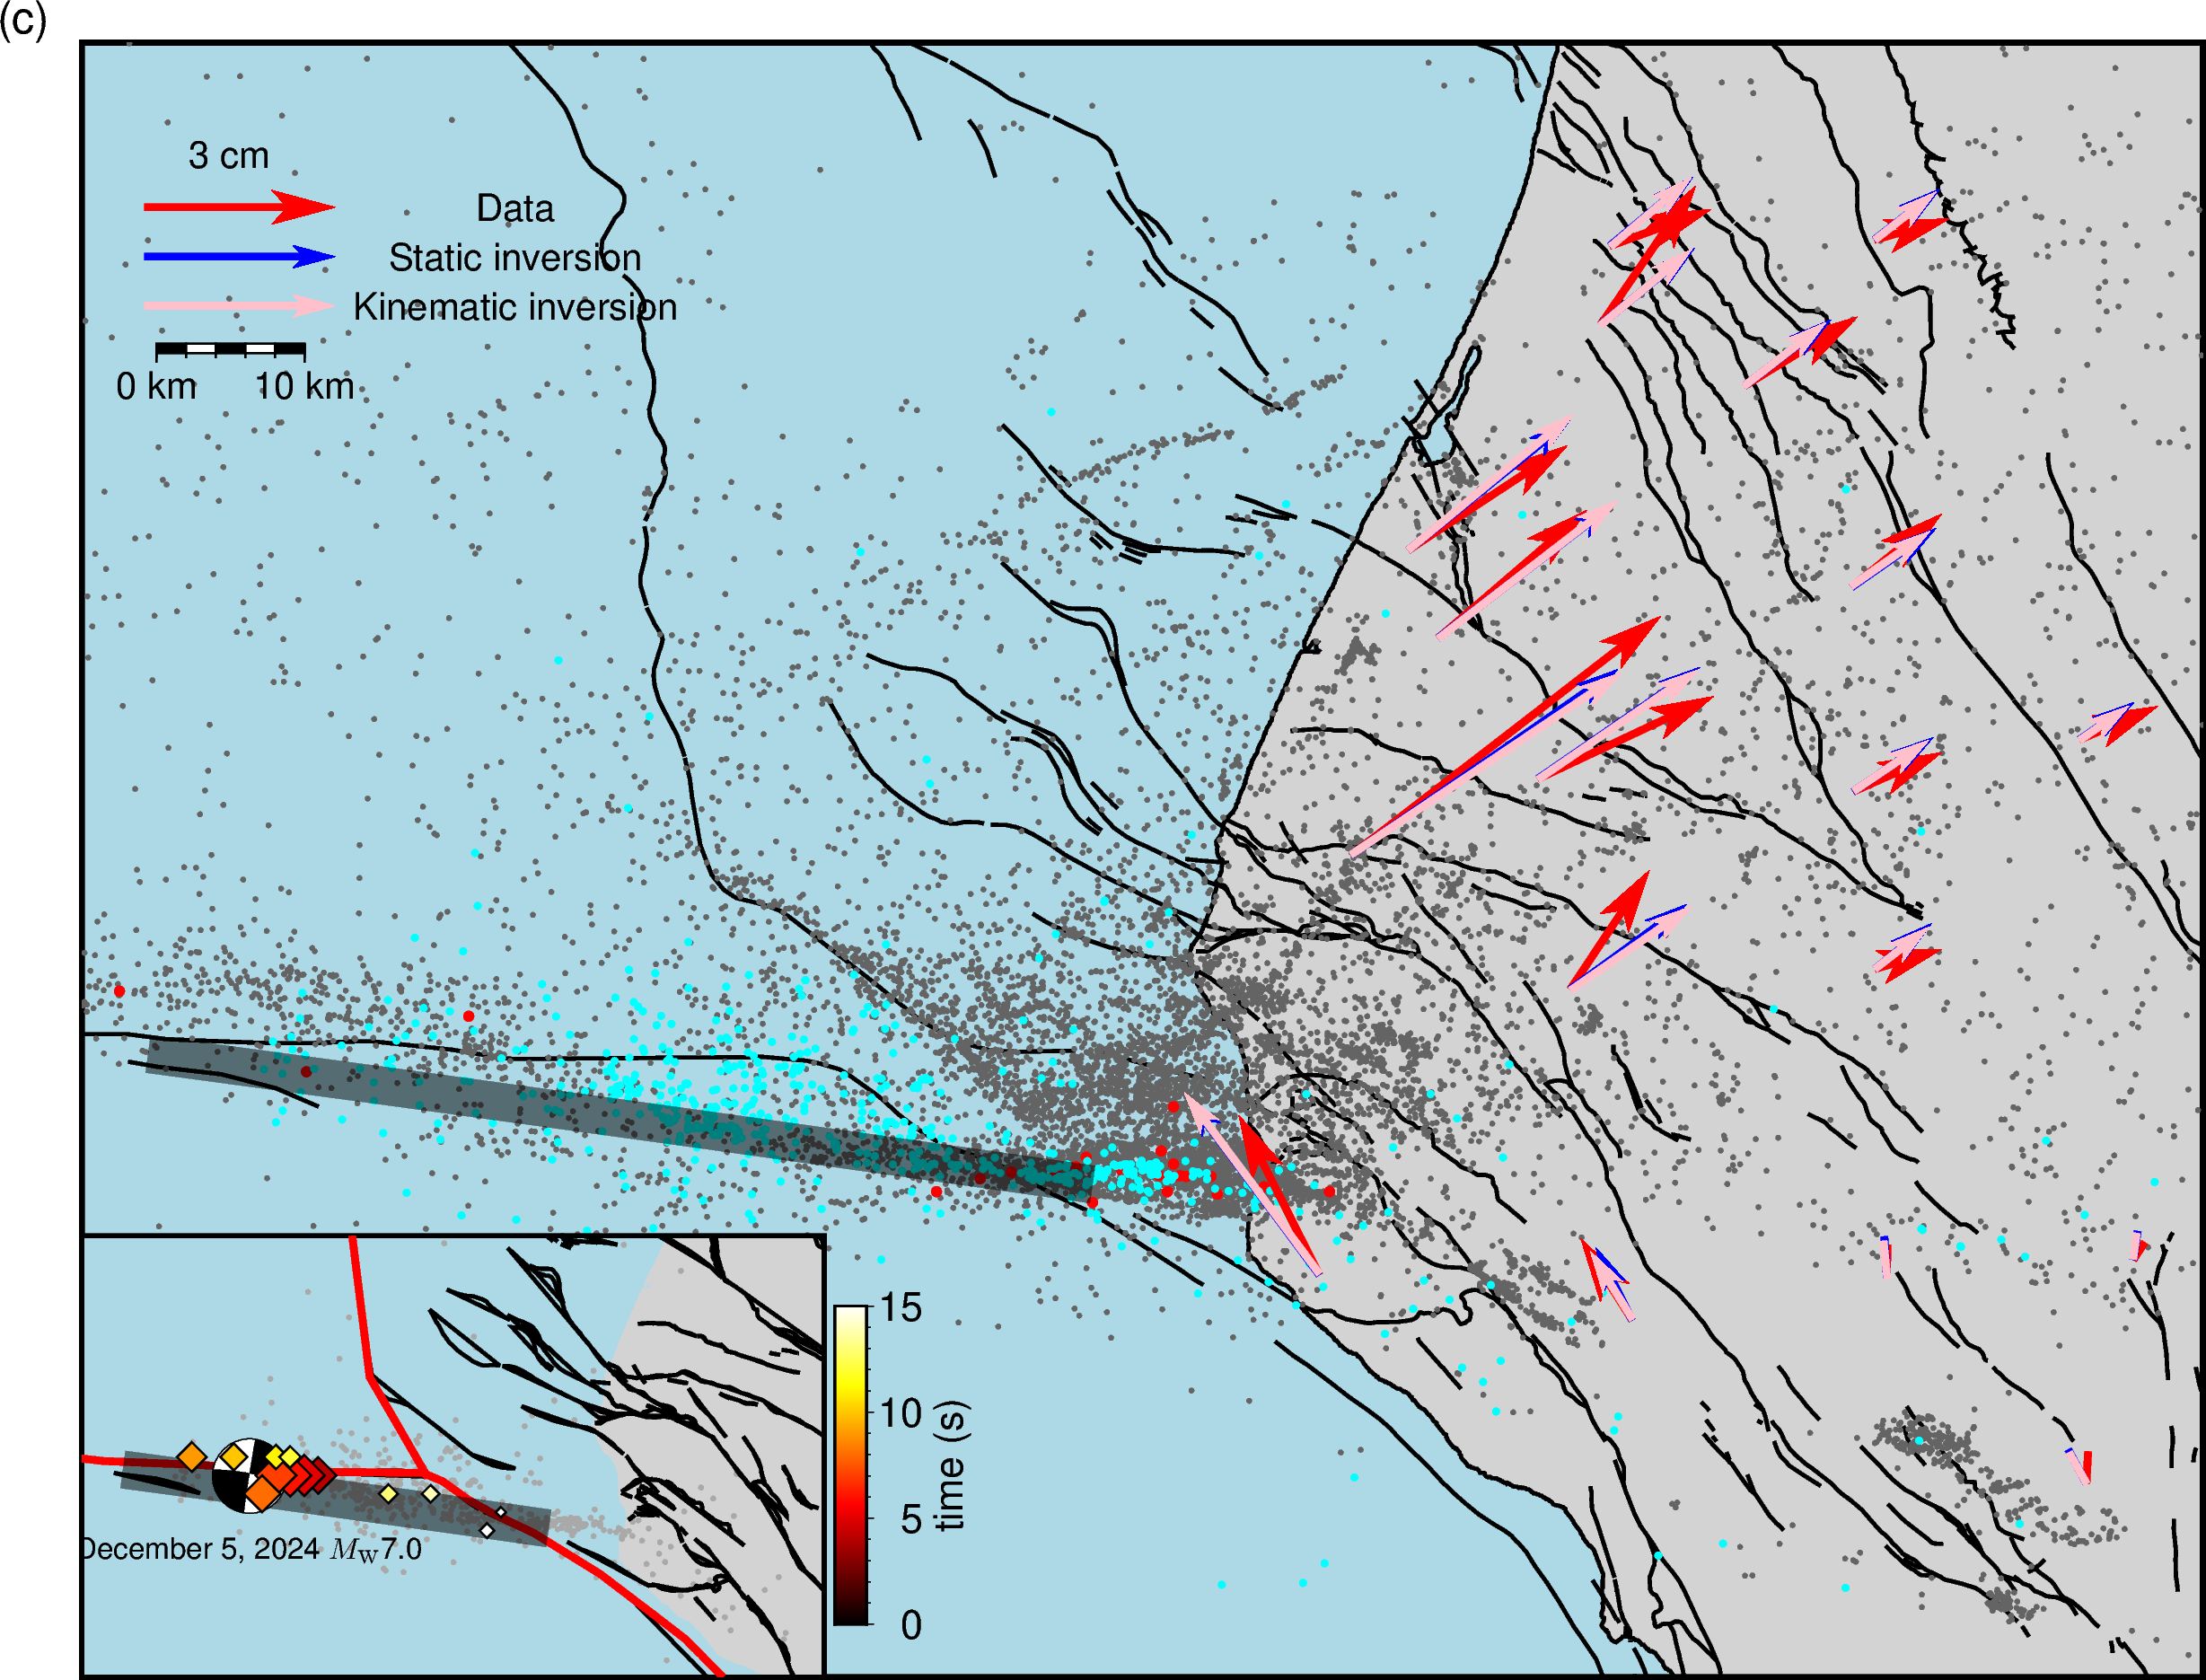

In [36]:
plot_kinematic = True
plot_seismicity  = True


region=[-125.3, -123.6, 40, 41]
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

#### panel c #####

fig.coast(
    frame=['lrtb'],
    projection=f"M20",
    region=region,
    shorelines='1p,black',
    land = 'lightgray',
    water='lightblue'
    
)
fig.plot(
    data='./faults.gmt',
    pen="1p,black",
)

if plot_seismicity:
    cc = 100
    fig.plot(
        x=background.lon,
        y=background.lat,
        style="c0.05c",
        fill=f'{cc}/{cc}/{cc}',
    )
    fig.plot(
        x=repeating_cat.lon,
        y=repeating_cat.lat,
        style="c0.1c",
        fill='red',
    )
    fig.plot(
        x=cat.lon,
        y=cat.lat,
        style="c0.07c",
        fill="cyan",
    )

spec="e60/0.39+f18"


disp = gnss[['id', 'lon', 'lat', 'E', 'N']]

fig.velo(
    data=disp.iloc[:, 1:],
    spec=spec,
    pen="2p,red",
    line=True,
    vector="0.6c+e+gred",
)
fig.velo(
    data=static_inv_gnss_syn[['lon', 'lat', 'E', 'N']],
    spec=spec,
    pen="2p,blue",
    line=True,
    vector="0.4c+e+gblue",
)
if plot_kinematic:
    fig.velo(
        data=kinematic_inv_gnss_syn[['lon', 'lat', 'E', 'N']],
        spec=spec,
        pen="2p,pink",
        line=True,
        vector="0.4c+e+gpink",
    )
size = 0.03
fig.velo(
    data=[[-125.25, 40.87, size, 0]],
    spec=spec,
    pen="2p,blue",
    line=True,
    vector="0.4c+e+gblue",
)
if plot_kinematic:
    fig.velo(
        data=[[-125.25, 40.84, size, 0]],
        spec=spec,
        pen="2p,pink",
        line=True,
        vector="0.4c+e+gpink",
    )
    fig.text(x=-125.25, y=40.84, text='Kinematic inversion', font="10p", offset='3.5c/0.0c') 

fig.velo(
    data=[[-125.25, 40.9, size, 0]],
    spec=spec,
    pen="2p,red",
    line=True,
    vector="0.6c+e+gred",
)
fig.text(x=-125.25, y=40.9, text='3 cm', font="10p", offset='0.8c/0.5c')
fig.text(x=-125.25, y=40.87, text='Static inversion', font="10p", offset='3.5c/0.0c') 
fig.text(x=-125.25, y=40.9, text='Data', font="10p", offset='3.5c/0.0c')

fig.plot(x=span_2024["lon"], y=span_2024["lat"], pen = "10p,black@50%")


fig.basemap(map_scale="n0.07/0.81+w10k+f+u")
fig.text(position='TL', no_clip=True, text='(c)', font='12p,Helvetica,black', offset='-0.8c/0.4c')
#################################################################################################################################################################################################################################
# inset
region3=[-125.32, -124, 40.1, 40.7]

fig.coast(
    frame=['tblr', 'xa0.5f0.1', 'ya0.5f0.1'],
    projection=f"M7",
    region=region3,
    land='lightgray',
    water='lightblue'
)
fig.plot(
    x=cat.lon,
    y=cat.lat,
    style="c0.05c",
    fill="darkgray",
    label='Lomax catalog'
)

fig.plot(data='../figure1/output.gmt', pen='1p,black', close=True)
fig.plot(data='../figure1/SAF_Men.gmt', pen='2p,red')
fig.plot(data='../figure1/cascedia.gmt', pen='2p,red')

fig.text(x=-125.15, y=41.3, text='Cascadia Subduction Zone', font='12p,red', angle=-75)
fig.text(x=-124.18, y=39.95, text='SAF', font='12p,red', angle=-75)
fig.plot(x=-123.95, y=39.8, style="v0.5c+ea+r+h0.1+a35", direction=([105], [1.5]), pen="1p,red", fill="red")
fig.plot(x=-124.15, y=40.05, style="v0.5c+ea+r+h0.1+a35", direction=([285], [1.5]), pen="1p,red", fill="red")
fig.text(x=-125.9, y=40.33, text='Mendocino Fault Zone', font='12p,red', angle=0)

focal_mechanism = [
    [280, 84, -179, 189, 89, -6, 4.028, 19]  # Single event
]

# Create a DataFrame to pass to pygmt.meca
focal_df = pd.DataFrame(focal_mechanism, columns=["strike1", "dip1", "rake1", "strike2", "dip2", "rake2", "mantissa", "exponent"])

# Event information (longitude, latitude, depth) and location for beachball
event_data = pd.DataFrame({
    "longitude": [-125.022],
    "latitude": [40.374],
    "depth": [10.0]
})

# Add the focal mechanism DataFrame to the event DataFrame
event_data = pd.concat([event_data, focal_df], axis=1)

fig.plot(x=span_2024["lon"], y=span_2024["lat"], pen = "10p,black@50%")
# Plot the beachball using GCMT convention
fig.meca(spec=event_data, scale="1.5c", offset=True) 
fig.text(x=-125.022, y=40.345, text='December 5, 2024 @[M_{\\textrm{w}}@[7.0', font='8p', angle=0, offset='0/-0.5c')

fig.plot(x=-126.15, y=40.38, style="v0.5c+ea+r+h0.1+a35", direction=([0], [1.5]), pen="1p,red", fill="red")
fig.plot(x=-125.83, y=40.45, style="v0.5c+ea+r+h0.1+a35", direction=([180], [1.5]), pen="1p,red", fill="red")
fig.plot(x=back_projection.lon, y=back_projection.lat, style="dd", size=0.4 * back_projection.beam_power, fill=back_projection.time, cmap='../figure1/back_projection.cpt', pen='0.5p')


# Add the color bar for depth
with pygmt.config(FONT_LABEL='24p,Helvetica,black', FONT_ANNOT_PRIMARY='24p,Helvetica,black'):
    fig.colorbar(
        cmap='../figure1/back_projection.cpt',  # Use the same colormap as in the mec plot
        position="JBR+w3c/0.3c+o0.1c/-3.5c",  # Position of the color bar
        frame='af+ltime (s)' # Label the color bar
    )

fig.show(width=1200)

In [17]:
span_2024={'lon':[-125.247, -124.490], 'lat':[40.383, 40.303]}

plot [WARNING]: Length <unit> d not supported - revert to default unit [cm]
plot [WARNING]:  not a valid number and may not be decoded properly.


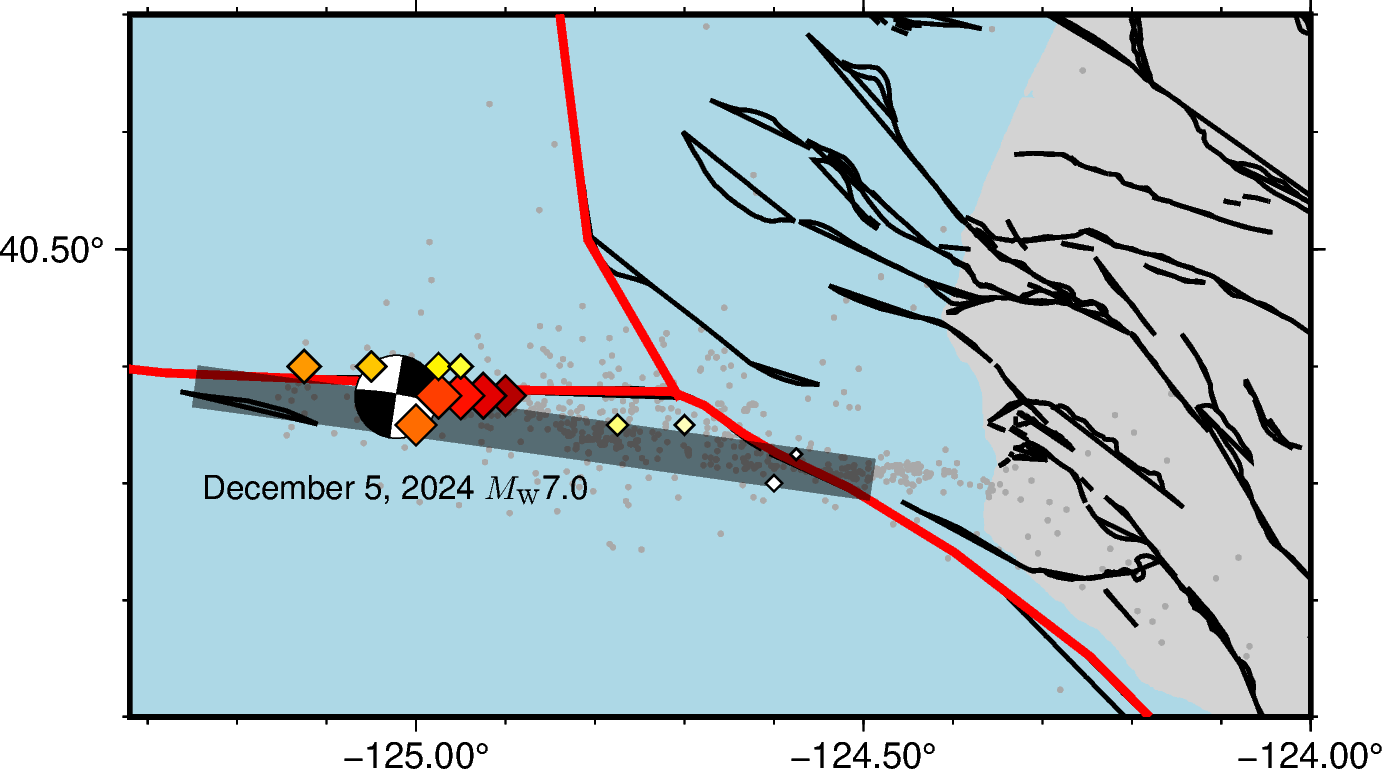

In [ ]:
fig = pygmt.Figure()

region3=[-125.32, -124, 40.1, 40.7]

fig.coast(
    frame=['WSne', 'xa0.5f0.1', 'ya0.5f0.1'],
    projection=f"M10",
    region=region3,
    land='lightgray',
    water='lightblue'
)


fig.plot(
    x=cat.lon,
    y=cat.lat,
    style="c0.05c",
    fill="darkgray",
    label='Lomax catalog'
)

fig.plot(data='../figure1/output.gmt', pen='1p,black', close=True)
fig.plot(data='../figure1/SAF_Men.gmt', pen='2p,red')
fig.plot(data='../figure1/cascedia.gmt', pen='2p,red')

fig.text(x=-125.15, y=41.3, text='Cascadia Subduction Zone', font='12p,red', angle=-75)
fig.text(x=-124.18, y=39.95, text='SAF', font='12p,red', angle=-75)
fig.plot(x=-123.95, y=39.8, style="v0.5c+ea+r+h0.1+a35", direction=([105], [1.5]), pen="1p,red", fill="red")
fig.plot(x=-124.15, y=40.05, style="v0.5c+ea+r+h0.1+a35", direction=([285], [1.5]), pen="1p,red", fill="red")
fig.text(x=-125.9, y=40.33, text='Mendocino Fault Zone', font='12p,red', angle=0)

focal_mechanism = [
    [280, 84, -179, 189, 89, -6, 4.028, 19]  # Single event
]

# Create a DataFrame to pass to pygmt.meca
focal_df = pd.DataFrame(focal_mechanism, columns=["strike1", "dip1", "rake1", "strike2", "dip2", "rake2", "mantissa", "exponent"])

# Event information (longitude, latitude, depth) and location for beachball
event_data = pd.DataFrame({
    "longitude": [-125.022],
    "latitude": [40.374],
    "depth": [10.0]
})

# Add the focal mechanism DataFrame to the event DataFrame
event_data = pd.concat([event_data, focal_df], axis=1)

fig.plot(x=span_2024["lon"], y=span_2024["lat"], pen = "10p,black@50%")
# Plot the beachball using GCMT convention
fig.meca(spec=event_data, scale="1.5c", offset=True) 
fig.text(x=-125.022, y=40.345, text='December 5, 2024 @[M_{\\textrm{w}}@[7.0', font='8p', angle=0, offset='0/-0.5c')

fig.plot(x=-126.15, y=40.38, style="v0.5c+ea+r+h0.1+a35", direction=([0], [1.5]), pen="1p,red", fill="red")
fig.plot(x=-125.83, y=40.45, style="v0.5c+ea+r+h0.1+a35", direction=([180], [1.5]), pen="1p,red", fill="red")
fig.plot(x=back_projection.lon, y=back_projection.lat, style="dd", size=0.4 * back_projection.beam_power, fill=back_projection.time, cmap='../figure1/back_projection.cpt', pen='0.5p')


fig.show(width=1200)